In [77]:
import importlib
import decorator
importlib.reload(decorator)

import sys
import time

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange

In [78]:
# Create an environment so that we can obtain information about it.
reference_env = gym.make("LunarLander-v2")
action_dim = reference_env.action_space.n
obs_dim = reference_env.observation_space.shape[0]

# Seed for all environments in this notebook.
env_seed = 52

In [81]:
import torch
import torch.nn as nn

#defining our model
class LanderAction(nn.Module):
    def __init__(self):
        super(LanderAction, self).__init__()
        self.regressor = torch.nn.Sequential(
                            torch.nn.Linear(8, 2),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(2, 2),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(2, 2),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(2, 4),
                        )
    def forward(self, x):
        output = self.regressor(x)
        return output

def count_parameters(model):
    #returns the number of TRAINABLE parameters in the model
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Our model has {count_parameters(LanderAction())} parameters')


def get_partition_list(model):
  '''
  returns the indices at which to slice a list if you want to reshape
  a long array into the parameters for the model

  e.g., your network has the following layers:
        1x2 FF (2 weight terms, 2 bias terms)
        2x2 FF (4 weight terms, 2 bias terms)
        2x1 FF (2 weight terms, 1 bias term)
    then this network has 13 parameters, and if a length 13 list is supplied,
    it should be cut at indices [2,4,8,10,12]
  '''
  partition_list = [0]

  for p in [p for p in model.parameters() if p.requires_grad]:
    partition_list.append(p.numel() + partition_list[-1])

  return partition_list[1:-1]

def vector_to_model(vector):
  '''
  takes in a vector with length==# model parameters and a model and loads the vector into the model
  (this function only works for our specific above model hehe)
  '''
  model = LanderAction()
  new_dict = {}
  sizes = get_partition_list(model)
  for key, value in zip(model.state_dict().keys(), np.split(vector, sizes)):
    new_dict[key] = torch.tensor(value).reshape(*model.state_dict()[key].shape)

  model.load_state_dict(new_dict)
  return model

print(vector_to_model(np.random.randn(count_parameters(LanderAction()))))

Our model has 42 parameters
LanderAction(
  (regressor): Sequential(
    (0): Linear(in_features=8, out_features=2, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=2, out_features=2, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=2, out_features=4, bias=True)
  )
)


In [138]:
def simulate(model, seed=None, video_env=None):
    """Simulates the lunar lander model.

    Args:
        model (np.ndarray): The array of weights for the linear policy.
        seed (int): The seed for the environment.
        video_env (gym.Env): If passed in, this will be used instead of creating
            a new env. This is used primarily for recording video during
            evaluation.
    Returns:
        total_reward (float): The reward accrued by the lander throughout its
            trajectory.
        impact_x_pos (float): The x position of the lander when it touches the
            ground for the first time.
        impact_y_vel (float): The y velocity of the lander when it touches the
            ground for the first time.
    """
    if video_env is None:
        # Since we are using multiple processes, it is simpler if each worker
        # just creates their own copy of the environment instead of trying to
        # share the environment. This also makes the function "pure." However,
        # we should use the video_env if it is passed in.
        env = gym.make("LunarLander-v2")
    else:
        env = video_env

    action_dim = env.action_space.n
    obs_dim = env.observation_space.shape[0]
    model = vector_to_model(model)

    total_reward = 0.0
    impact_x_pos = None
    impact_y_vel = None
    all_y_vels = []
    steps = 0
    obs, _ = env.reset(seed=seed)
    done = False

    while not done:
        steps += 1
        output = model(torch.tensor(obs, requires_grad=False)).detach().numpy()
        action = np.argmax(output)  # Linear policy.
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward + .2

        

        # Refer to the definition of state here:
        # https://gymnasium.farama.org/environments/box2d/lunar_lander/
        x_pos = obs[0]
        y_vel = obs[3]
        leg0_touch = bool(obs[6])
        leg1_touch = bool(obs[7])
        all_y_vels.append(y_vel)

        # Check if the lunar lander is impacting for the first time.
        if impact_x_pos is None and (leg0_touch or leg1_touch):
            impact_x_pos = x_pos
            impact_y_vel = y_vel
            impact_step = steps

        if steps >= 600:
            done = True

    # If the lunar lander did not land, set the x-pos to the one from the final
    # timestep, and set the y-vel to the max y-vel (we use min since the lander
    # goes down).
    if impact_x_pos is None:
        impact_x_pos = x_pos
        impact_y_vel = min(all_y_vels)
        impact_step = 500

    # Only close the env if it was not a video env.
    if video_env is None:
        env.close()

    return total_reward, impact_x_pos, impact_y_vel, impact_step

In [139]:
print(simulate(np.random.randn(count_parameters(LanderAction()))))

(-813.8769316857807, 0.0024767877, -1.860965, 84)


In [140]:
from ribs.archives import GridArchive
initial_model = np.zeros((action_dim, obs_dim))

archive = GridArchive(
    solution_dim=count_parameters(LanderAction()),  # Dimensionality of solutions in the archive.
    dims=[30, 30, 20],  # 50 cells along each dimension.
    ranges=[(-1.0, 1.0), (-1.5, 0.0), (50,600)],  # (-1, 1) for x-pos and (-3, 0) for y-vel.
    qd_score_offset=-600,  # See the note below.
)

In [141]:
from ribs.emitters import EvolutionStrategyEmitter

emitters = [
    EvolutionStrategyEmitter(
        archive=archive,
        x0=5*np.random.randn(count_parameters(LanderAction())),
        sigma0=5.0,  # Initial step size.
        ranker="2imp",
        batch_size=30,  # If we do not specify a batch size, the emitter will
                        # automatically use a batch size equal to the default
                        # population size of CMA-ES.
    ) for _ in range(5)  # Create 5 separate emitters.
]

In [142]:
from ribs.schedulers import Scheduler

scheduler = Scheduler(archive, emitters)

In [143]:
start_time = time.time()
total_itrs = 300

for itr in trange(1, total_itrs + 1, file=sys.stdout, desc='Iterations'):
    # Request models from the scheduler.
    sols = scheduler.ask()

    # Evaluate the models and record the objectives and measuress.
    # futures = client.map(lambda model: simulate(model, env_seed), sols)
    # results = client.gather(futures)
    results = [simulate(model, env_seed) for model in sols]

    objs, meas = [], []
    for obj, impact_x_pos, impact_y_vel, steps in results:
        objs.append(obj)
        meas.append([impact_x_pos, impact_y_vel, steps])

    # Send the results back to the scheduler.
    scheduler.tell(objs, meas)

    # Logging.
    if itr % 25 == 0:
        tqdm.write(f"> {itr} itrs completed after {time.time() - start_time:.2f}s")
        tqdm.write(f"  - Size: {archive.stats.num_elites}")    # Number of elites in the archive. len(archive) also provides this info.
        tqdm.write(f"  - Coverage: {archive.stats.coverage}")  # Proportion of archive cells which have an elite.
        tqdm.write(f"  - QD Score: {archive.stats.qd_score}")  # QD score, i.e. sum of objective values of all elites in the archive.
                                                               # Accounts for qd_score_offset as described in the GridArchive section.
        tqdm.write(f"  - Max Obj: {archive.stats.obj_max}")    # Maximum objective value in the archive.
        tqdm.write(f"  - Mean Obj: {archive.stats.obj_mean}")  # Mean objective value of elites in the archive.

> 25 itrs completed after 20.69s                                                                           
  - Size: 618                                                                                              
  - Coverage: 0.034333333333333334                                                                         
  - QD Score: 237176.19248734915                                                                           
  - Max Obj: 261.4681593827179                                                                             
  - Mean Obj: -216.2197532567166                                                                           
> 50 itrs completed after 54.45s                                                                           
  - Size: 1588                                                                                             
  - Coverage: 0.08822222222222222                                                                          
  - QD Score: 759082.6451413

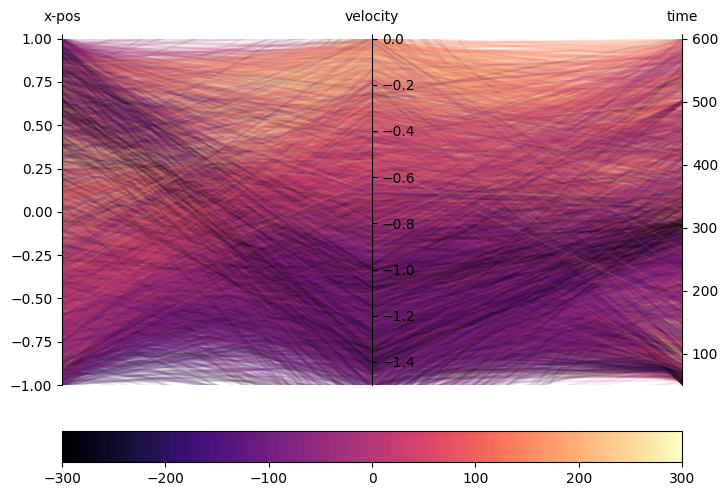

In [144]:
from ribs.visualize import grid_archive_heatmap, parallel_axes_plot

plt.figure(figsize=(8, 6))
parallel_axes_plot(archive, vmin=-300, vmax=300, alpha=.1, measure_order=[(0,'x-pos'),(1,'velocity'),(2,'time')])

In [145]:
import base64
import glob
import io

from IPython.display import display, HTML


def display_video(model):
    """Displays a video of the model in the environment."""

    video_env = gym.wrappers.RecordVideo(
        gym.make("LunarLander-v2", render_mode="rgb_array"),
        video_folder="videos",
        # This will ensure all episodes are recorded as videos.
        episode_trigger=lambda idx: True,
        # Disables moviepy's logger to reduce clutter in the output.
        disable_logger=True,
    )
    simulate(model, env_seed, video_env)
    video_env.close()  # Save video.

    # Display the video with HTML. Though we use glob, there is only 1 video.
    for video_file in glob.glob("videos/*.mp4"):
        video = io.open(video_file, 'rb').read()
        encoded = base64.b64encode(video).decode("ascii")
        display(
            HTML(f'''
            <video width="360" height="auto" controls>
                <source src="data:video/mp4;base64,{encoded}" type="video/mp4" />
            </video>'''))
from moviepy.config import change_settings
change_settings({"FFMPEG_BINARY": "/opt/homebrew/bin/ffmpeg"})


In [146]:
print(simulate(archive.best_elite['solution'], env_seed))
print(archive.best_elite)
display_video(archive.best_elite['solution'])

(395.6078260090994, -0.40800652, -0.12372924, 121)
{'solution': array([-25.97172876,  -9.13197706, -40.52291841,  59.08765238,
        15.50073286,  18.08251323,  10.92345914,  15.07559817,
         9.69319919,  30.60677236,  13.01950997,  50.17556349,
       -39.38227874, -22.96585181, -16.81321683, -23.28927265,
        16.02742976,   3.99012451,  -9.68902589,  29.50450071,
         6.03697431,  -0.32593892,  -2.49266871,  16.45107337,
        39.10773176, -16.21718501,  -9.25540652, -13.31850593,
       -34.13315483,  19.84445027,  -5.36466391,  53.5310925 ,
        24.55320119,  -8.83235842,   9.82665901,  -4.96496756,
        -6.16856764, -11.02589553,  -8.05116161,  37.3493394 ,
        85.66955534, -12.37431253]), 'objective': 395.6078260090994, 'measures': array([ -0.40800652,  -0.12372924, 121.        ]), 'threshold': 395.6078260090994, 'index': 5342}


/Users/ndennler/.pyenv/versions/3.11.6/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/ndennler/Desktop/preference-based-optimization/applications/lunar_lander/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [171]:
occupied, elite = archive.retrieve_single([0.7, -.05, 150])
# `occupied` indicates if there was an elite in the corresponding cell.
if occupied:
    print(simulate(elite['solution']))
    display_video(elite["solution"])

(-256.9830134594533, 0.13855438, -0.39471513, 201)


In [172]:
df = archive.data(return_type="pandas")
high_perf_sols = df.query("objective > 200").sort_values("objective", ascending=False)

In [173]:
print(len(high_perf_sols))

2133


In [174]:
if len(high_perf_sols) > 0:
    for elite in high_perf_sols.iloc[[0, len(high_perf_sols) // 2, -1]].iterelites():
        print(f"Objective: {elite['objective']}")
        print(f"Measures: (x-pos: {elite['measures'][0]}, y-vel: {elite['measures'][1]})")
        display_video(elite['solution'])

Objective: 395.6078260090994
Measures: (x-pos: -0.4080065190792084, y-vel: -0.12372923642396927)


/Users/ndennler/.pyenv/versions/3.11.6/lib/python3.11/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/ndennler/Desktop/preference-based-optimization/applications/lunar_lander/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Objective: 287.24690142871947
Measures: (x-pos: 0.08996286243200302, y-vel: -0.34202802181243896)


Objective: 200.00211849482838
Measures: (x-pos: -0.38757023215293884, y-vel: -0.11757037788629532)
